In [98]:
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from numpy.lib import stride_tricks
import cv2
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
import sys

np.set_printoptions(precision=3)

class PatchMatch(object):
    def __init__(self, a, b, patch_size):
        assert a.shape == b.shape, "Dimensions were unequal for patch-matching input"
        
        self.orig_shape = a.shape
        self.patch_size = patch_size
        self.offset_from_edge = self.patch_size // 2
        offset_from_edge = self.offset_from_edge
        self.a = a
        self.b = b
        
        self.a_padded = np.pad(a,pad_width=((0,0),(offset_from_edge,offset_from_edge),(offset_from_edge,offset_from_edge)),mode='reflect')
        
        self.b_padded = np.pad(b,pad_width=((0,0),(offset_from_edge,offset_from_edge),(offset_from_edge,offset_from_edge)),mode='reflect')
        
        
        self.nnf = np.ndarray(shape=(2, a.shape[1], a.shape[2]),dtype=np.int32)
        self.nnd = np.ndarray(shape=(a.shape[1], a.shape[2]))

        #print(self.a.shape)
        #print(self.b.shape)
        #print("SHAPE OF PADDED a {}".format(self.a_padded.shape))
        #print("SHAPE OF PADDED b {}".format(self.b_padded.shape))


    
        for i in range(0, a.shape[1] ): #loop  through y
            for j in range(0, a.shape[2]): # loop through x
                self.nnf[0][i][j] = int(np.random.randint(0,a.shape[2]))
                self.nnf[1][i][j] = int(np.random.randint(0,a.shape[1]))
                self.nnd[i][j] = self.calculate_distance(j,i,self.nnf[0][i][j],self.nnf[1][i][j])
                
    def clean_coords(self,x,y):
        assert x >= self.offset_from_edge and x < self.orig_shape[2] , "X coordinate off"
        assert y >= self.offset_from_edge and y < self.orig_shape[1] , "Y coordinate off"
        
    def _pad_matrix(self, matr):
        offset_from_edge = self.offset_from_edge
        return np.pad(matr,pad_width=((0,0),(offset_from_edge,offset_from_edge),(offset_from_edge,offset_from_edge)),mode='reflect')
    
    def calculate_distance(self,ax,ay,bx,by):

        patch_a = self.get_patch_for_coords(self.a_padded,ax,ay)
        patch_b = self.get_patch_for_coords(self.b_padded,bx,by)
        
#         print(patch_a.shape)
#         print(patch_b.shape)
        assert patch_a.shape == patch_b.shape, " ax {}  ay {}  bx {}  by {} a.shape = {}  b.shape={}".format(ax,ay,bx,by,patch_a.shape,patch_b.shape)


        diff = patch_a - patch_b
        distances = np.linalg.norm(diff,axis=0)
#         print("DISTANCE {}".format(distances.size))
        average = np.sum(distances)/(distances.size)
        return average
        
        
    
    def get_patch_for_coords(self, arr, x, y,patch_size=None):
        """
        Get a patch of at max patch_size X patch_size.
        x and y denotes the center of the patch

        :arr: an array of dimensions C * H * W 
        :return:
        """
#         x,y = self.clip_coords(x,y)
        if patch_size is None:
            patch_size = self.patch_size
        
        return arr[:,y: y + patch_size,
                     x : x+patch_size ]
        

        return arr[ : , y : y+self.offset_from_edge, x:x+self.offset_from_edge]
    
    def propagate(self):
        old_nnd = self.nnd.copy()
        #print(self.nnd)
        #print("-"*10)
        for i in range(1,self.orig_shape[1]): # loop through ys
            for j in range(1,self.orig_shape[2]):# loop through xs
                current_pos_distance = self.nnd[i][j] 
                
                horiz_x = j - 1
                horiz_y = i
                horiz_dist = self.calculate_distance(j,i,self.nnf[0][horiz_y][horiz_x],self.nnf[1][horiz_y][horiz_x])
                
                vert_x = j 
                vert_y = i - 1  
                vert_dist = self.calculate_distance(j,i,self.nnf[0][vert_y][vert_x],self.nnf[1][vert_y][vert_x])

                best_dist = min(current_pos_distance,horiz_dist,vert_dist)
                
                if best_dist == current_pos_distance:
                    best_x = j
                    best_y = i
                elif best_dist == horiz_dist:
                    best_x = horiz_x
                    best_y = horiz_y
                elif best_dist == vert_dist:
                    best_x = vert_x
                    best_y = vert_y
                    
                rand_d = min(self.a.shape[1]//2, self.a.shape[2]//2)
                
                while rand_d > 0:
                        xmin = max(best_x - rand_d, 0)
                        xmax = min(best_x + rand_d, self.b.shape[2])
                        ymin = max(best_y - rand_d, 0)
                        ymax = min(best_y + rand_d, self.b.shape[1])

                        rand_x = np.random.randint(xmin, xmax)
                        rand_y = np.random.randint(ymin, ymax)
                        val = self.calculate_distance(j,i, rand_x, rand_y)
                        if val < best_dist:
                            best_x, best_y, best_dist = rand_x, rand_y, val
                        rand_d = rand_d // 2    
              
                self.nnf[0][i][j] = best_x 
                self.nnf[1][i][j] = best_y
                self.nnd[i][j] = best_dist
            if i % 10 == 0:
                pass
                #pm.reconstruct_img_alt(patch_size=5)


        #print(self.nnd)
        #print("_"*10)
        #print(old_nnd-self.nnd)
            
    
    def get_loss_value(self):
        return np.sum(self.nnd)
    def clip_coords(self,x,y):
        return max(x,0) , max(y,0)
    
    def reconstruct_img_alt(self, patch_size=3):
        if patch_size is None:
            patch_size = self.patch_size
        
        padded_nnf = self._pad_matrix(self.nnf)
        b_prime = np.zeros_like(self.a,dtype=np.uint8)
        
        for i in range(self.a.shape[1]): #traverse down a
            for j in range(self.a.shape[2]): #traverse across a
                
                #get patch around (i,j) in nnf
                nnf_patch = self.get_patch_for_coords(padded_nnf, j, i,patch_size=patch_size)
                warped_patch = np.zeros(shape=(3, patch_size, patch_size), dtype=self.b.dtype)

                #warp the patch with pixel values from b according to nnf locations
                for p_x in range(nnf_patch.shape[1]):
                    for p_y in range(nnf_patch.shape[2]):
                        warped_patch[:, p_x, p_y] = self.b[:, nnf_patch[1][p_x][p_y], nnf_patch[0][p_x][p_y]]
                
                #average the pixels in the warped patch to get the reconstructed image's pixel
                averaged_patch = warped_patch.sum(axis=(1,2))/(patch_size*patch_size)
                if i == self.a.shape[1] // 2 and j == self.a.shape[2] // 2:
                    print(i, j, nnf_patch, averaged_patch)
                    #sys.exit()
                b_prime[:, i, j] = averaged_patch[:]
                
        b_prime = np.rollaxis(b_prime, 0, 3)
        plt.imshow(b_prime[:, :, ::-1])
    
    def reconstruct_img(self,patch_size=3):
        if patch_size is None:
            patch_size = self.patch_size
            
        img = np.zeros(shape=(3,200,200),dtype=np.uint8)

        for i in range(200):
            for j in range(200):
                t_x = pm.nnf[0][i][j] 
                t_y = pm.nnf[1][i][j]
                patch = self.get_patch_for_coords(self.b_padded, t_y, t_x,patch_size=patch_size)
                average_vote = patch.sum(axis=(1,2))/(patch_size*patch_size)
                
                
        #         print(t_x)
        #         print(t_y)
        #         print()
                img[0][i][j] = average_vote[0]
                img[1][i][j] = average_vote[1]
                img[2][i][j] = average_vote[2]
        #         print(y[0][t_y][t_x])
        #         print(y[1][t_y][t_x])
        #         print(y[2][t_y][t_x])
        #         print()
        #         print(np.unique(img))

        #         print(img[0,j,i])
        #         print(img[1,j,i])
        #         print(img[2,j,i])
        #         print()
        plt.imshow(img.transpose(1,2,0)[:,:,::-1])
       
        
    def back_propagate(self):
            old_nnd = self.nnd.copy()
            #print(self.nnd)
            #print("-"*10)
            for i in range(self.orig_shape[1]-2,0,-1): # loop through ys
                for j in range(self.orig_shape[2]-2,0,-1):# loop through xs
                    current_pos_distance = self.nnd[i][j] 

                    horiz_x = j + 1
                    horiz_y = i
                    horiz_dist = self.calculate_distance(j,i,self.nnf[0][horiz_y][horiz_x],self.nnf[1][horiz_y][horiz_x])

                    vert_x = j 
                    vert_y = i + 1  
                    vert_dist = self.calculate_distance(j,i,self.nnf[0][vert_y][vert_x],self.nnf[1][vert_y][vert_x])

                    best_dist = min(current_pos_distance,horiz_dist,vert_dist)

                    if best_dist == current_pos_distance:
                        best_x = j
                        best_y = i
                    elif best_dist == horiz_dist:
                        best_x = horiz_x
                        best_y = horiz_y
                    elif best_dist == vert_dist:
                        best_x = vert_x
                        best_y = vert_y

                    rand_d = min(self.a.shape[1]//2, self.a.shape[2]//2)

                    while rand_d > 0:
                            xmin = max(best_x - rand_d, 0)
                            xmax = min(best_x + rand_d, self.b.shape[2])
                            ymin = max(best_y - rand_d, 0)
                            ymax = min(best_y + rand_d, self.b.shape[1])

                            rand_x = np.random.randint(xmin, xmax)
                            rand_y = np.random.randint(ymin, ymax)
                            val = self.calculate_distance(j,i, rand_x, rand_y)
                            if val < best_dist:
                                best_x, best_y, best_dist = rand_x, rand_y, val
                            rand_d = rand_d // 2    

                    self.nnf[0][i][j] = best_x 
                    self.nnf[1][i][j] = best_y
                    self.nnd[i][j] = best_dist
            #print(self.nnd)
            #print("_"*10)
            #print(old_nnd-self.nnd)



In [99]:
# test_a = np.random.randint(low=0,high=10,size=(7,100, 100))
# test_b = np.random.randint(low=0,high=10,size=(7,100, 100))

x = cv2.imread("./yellow.jpg")
y = cv2.imread("./blue.jpg")
x = cv2.resize(x,(200,200))
y = cv2.resize(y,(200,200))
# a = x.transpoe(2,1,0)
# b = y.transpose(2,1,0)
a = np.rollaxis(x, 2, 0)
b = np.rollaxis(y, 2, 0)

iteration 1
100 100 [[[ 99 100 101]
  [  5  99  14]
  [ 99 100 101]]

 [[ 99  99  99]
  [186 100  27]
  [101 101 100]]] [ 192.778  124.333   56.667]


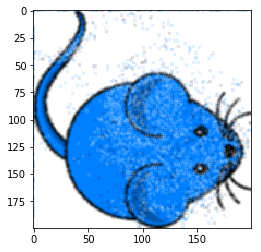

[[131  83   2 ...,  17  65 164]
 [122   1   1 ..., 197 197 199]
 [148   1   1 ..., 196 197 198]
 ..., 
 [ 33   1   2 ..., 197 197 198]
 [ 73   1   2 ..., 197 197 198]
 [147   0   1 ..., 196 197 199]]
iteration 2
100 100 [[[ 99 100 101]
  [136  99 101]
  [ 99 100 101]]

 [[ 99  99  98]
  [ 22 100 100]
  [100 101 101]]] [ 183.889  105.667   28.333]


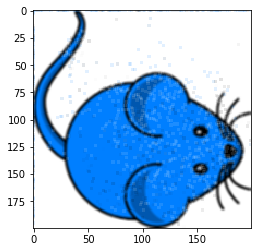

[[131  83   2 ...,  17  65 164]
 [122   1   2 ..., 197 198 199]
 [148   1   2 ..., 197 198 199]
 ..., 
 [ 33   1   2 ..., 197 198 199]
 [ 73   1   2 ..., 197 198 199]
 [147   1   2 ..., 197 198 199]]


In [100]:
patch_size=3
pm = PatchMatch(a, b, patch_size)
for i in range(2):
    print('iteration {}'.format(i+1))
    pm.propagate()
#         pm.back_propagate()
    pm.reconstruct_img_alt(patch_size=patch_size)
    plt.show()
    print(pm.nnf[0])

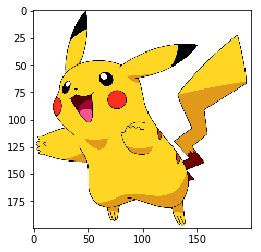

In [45]:
plt.imshow(x[:, :, ::-1])
#plt.imshow(np.rot90(pm.b.transpose(1,2,0)[:, :, ::-1]))
plt.show()

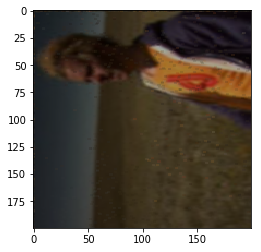

In [105]:
pm.reconstruct_img_alt(patch_size=3)

In [ ]:
pm.propagate()
pm.back_propagate()
pm.propagate()
pm.back_propagate()
pm.propagate()
pm.back_propagate()
pm.reconstruct_img(patch_size=3)
plt.show()

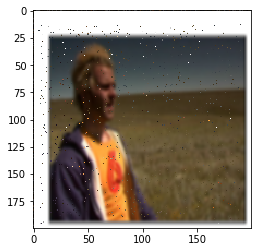

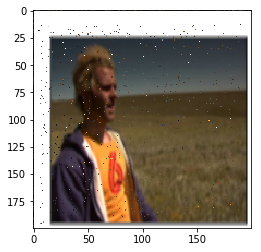

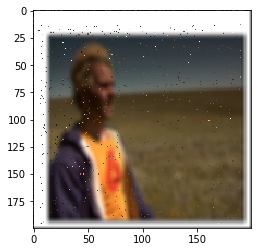

In [160]:
pm.reconstruct_img(patch_size=3)
plt.show()
pm.reconstruct_img(patch_size=1)
plt.show()
pm.reconstruct_img(patch_size=5)
plt.show()



[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

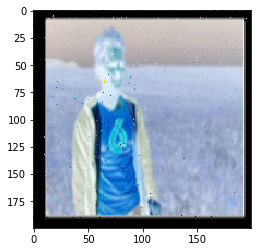

In [161]:
reconstruct()

In [ ]:
pm.get_patch_for_coords(x,0,0)

(3, 275, 183)


In [ ]:
x[:,0:3,0:3]

In [ ]:
pm.a[:,7+2,8+2]

In [46]:
pm.nnf[:,0,0] = [2,2]

In [47]:
pm.nnf[:,0,0]

array([2, 2], dtype=int32)

In [97]:
x = cv2.imread("/Users/harshvardhangupta/Deep-Image-Analogy/notebooks/Unknown.jpeg").transpose(2,1,0)
# x = x[:,:4,:4]
# x

array([[[  0, 197,  90,   5],
        [  0, 190,  82,  39],
        [ 63, 175,   0,  89],
        [122, 163,   7, 121]],

       [[ 19, 214,  89,   0],
        [ 33, 207,  81,  30],
        [ 96, 194,   0,  81],
        [156, 182,   6, 113]],

       [[ 28, 223,  99,   6],
        [ 42, 216,  91,  40],
        [105, 202,   7,  88],
        [162, 190,  16, 120]]], dtype=uint8)

In [99]:
np.pad(x,pad_width=((0,0),(1,1),(1,1)),mode='constant')

array([[[  0,   0,   0,   0,   0,   0],
        [  0,   0, 197,  90,   5,   0],
        [  0,   0, 190,  82,  39,   0],
        [  0,  63, 175,   0,  89,   0],
        [  0, 122, 163,   7, 121,   0],
        [  0,   0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0,   0],
        [  0,  19, 214,  89,   0,   0],
        [  0,  33, 207,  81,  30,   0],
        [  0,  96, 194,   0,  81,   0],
        [  0, 156, 182,   6, 113,   0],
        [  0,   0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0,   0],
        [  0,  28, 223,  99,   6,   0],
        [  0,  42, 216,  91,  40,   0],
        [  0, 105, 202,   7,  88,   0],
        [  0, 162, 190,  16, 120,   0],
        [  0,   0,   0,   0,   0,   0]]], dtype=uint8)

In [165]:
pm.get_patch_for_coords(pm.a_padded,5,5)

array([[[ 0, 32],
        [ 4, 15]],

       [[ 3, 35],
        [ 6, 19]],

       [[ 0, 26],
        [ 0,  8]]], dtype=uint8)

In [144]:
x[:,y+self.offset_from_edge: y + self.patch_size , x+self.offset_from_edge : x+self.patch_size]

NameError: name 'self' is not defined

In [126]:
x[:,36+1 : 36 + 4 , 36+1 : 36+4]

array([[[92, 92, 92],
        [94, 94, 94],
        [95, 95, 95]],

       [[54, 54, 54],
        [56, 56, 56],
        [57, 57, 57]],

       [[36, 36, 36],
        [38, 38, 38],
        [39, 39, 39]]], dtype=uint8)

In [127]:
ax 36  ay 0  bx 182  by 8

SyntaxError: invalid syntax (<ipython-input-127-18d286b8d8a4>, line 1)

In [145]:
x[:,8+1:8+3,182+1:182+3]

array([], shape=(3, 2, 0), dtype=uint8)

In [146]:
x.shape

(3, 275, 183)

In [153]:
padded_x = np.pad(x,pad_width=((0,0),(1,1),(1,1)),mode='constant')

In [142]:
x.shape

(3, 275, 183)

In [154]:
padded_x

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0, 197, ...,  48,  48,   0],
        [  0,   0, 190, ...,  48,  48,   0],
        ..., 
        [  0, 231, 231, ...,  48,  48,   0],
        [  0, 231, 231, ...,  48,  48,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,  19, 214, ...,  22,  22,   0],
        [  0,  33, 207, ...,  22,  22,   0],
        ..., 
        [  0, 251, 251, ...,  22,  22,   0],
        [  0, 251, 251, ...,  22,  22,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,  28, 223, ...,  22,  22,   0],
        [  0,  42, 216, ...,  22,  22,   0],
        ..., 
        [  0, 255, 255, ...,  22,  22,   0],
        [  0, 255, 255, ...,  22,  22,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)

In [162]:
padded_x[:,8:8+4,182:182+3]

array([[[48, 48,  0],
        [48, 48,  0],
        [49, 49,  0]],

       [[22, 22,  0],
        [22, 22,  0],
        [23, 23,  0]],

       [[22, 22,  0],
        [22, 22,  0],
        [23, 23,  0]]], dtype=uint8)

In [7]:
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all='raise')

def unit_vector(vector):
    try:
        result = vector / np.linalg.norm(vector)
        return result
    except:
        print(vector)

def angle_between(v1, v2):
    v1, v2 = np.array(v1,dtype=np.float32), np.array(v2,dtype=np.float32)
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def norm_dist(arr):
    return (arr)/(arr.max())

def visualize_nnf(nnf, nnd):
    img = np.zeros((nnf.shape[1], nnf.shape[2], 3),dtype=np.float32)
    for i in range(1, nnf.shape[1]):
        for j in range(1, nnf.shape[2]):
            angle = angle_between([j, i], [nnf[0, i, j], nnf[1, i, j]])
            img[i, j, :] = np.array([angle, nnd[i,j], 1.0])
    img = hsv_to_rgb(norm_dist(img*255))
    plt.imshow(img)

In [7]:
visualize_nnf(pm.nnf,pm.nnd.T)

[ 0.  0.]


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [69]:
pm.nnf.dtype

dtype('int32')

In [262]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):

    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


def visualize_nnf(nnf, nnd):
    img = np.zeros((nnf.shape[1], nnf.shape[2], 3),dtype=np.float32)
    for i in range(1, nnf.shape[1]):
        for j in range(1, nnf.shape[2]):
            angle = angle_between([j, i], [nnf[0, i, j], nnf[1, i, j]])
            img[i, j, :] = np.array([angle, nnd[i,j], 1.0])
    img = hsv_to_rgb(norm_dist(img*255))
    plt.imshow(img)

In [275]:
tx = np.array([1,1],dtype=np.int32)
ty = np.array([0,0],dtype=np.int32)


angle_between((0, 0), (1,1))

FloatingPointError: invalid value encountered in true_divide

In [5]:
plt.imshow(pm.nnd.T/255)

NameError: name 'plt' is not defined

In [358]:
pm.nnd.shape

(100, 100)

In [359]:
pm.nnf.shape

(2, 100, 100)

In [134]:
def reconstruct():
    img = np.zeros(shape=(3,200,200),dtype=np.uint8)

    for i in range(200):
        for j in range(200):
            t_x = pm.nnf[0][i][j] 
            t_y = pm.nnf[1][i][j]
    #         print(t_x)
    #         print(t_y)
    #         print()
            img[0][i][j] = y[0][t_y][t_x]
            img[1][i][j] = y[1][t_y][t_x]
            img[2][i][j] = y[2][t_y][t_x]
    #         print(y[0][t_y][t_x])
    #         print(y[1][t_y][t_x])
    #         print(y[2][t_y][t_x])
    #         print()
    #         print(np.unique(img))

    #         print(img[0,j,i])
    #         print(img[1,j,i])
    #         print(img[2,j,i])
    #         print()
    plt.imshow(img.transpose(2,1,0)[:,:,::-1]*255)
    print(np.unique(img))

[0]


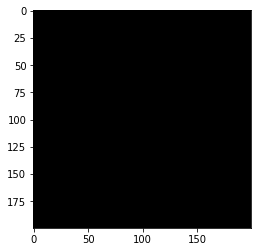

In [135]:
reconstruct()

In [311]:
np.unique(img)

array([ 255.], dtype=float32)

In [376]:
y[:,20:50,20:50]

array([[[ 81,  84,  85, ...,  56,  60,  64],
        [ 82,  84,  85, ...,  60,  66,  75],
        [ 83,  85,  87, ...,  70,  75,  73],
        ..., 
        [ 82,  86,  89, ...,  50,  56,  69],
        [ 82,  86,  89, ...,  69,  65,  62],
        [ 82,  86,  88, ...,  78,  72,  67]],

       [[ 82,  86,  88, ...,  81,  74,  63],
        [ 82,  85,  87, ...,  61,  56,  57],
        [ 83,  85,  87, ...,  55,  55,  54],
        ..., 
        [ 86,  89,  92, ...,  78,  85, 103],
        [ 85,  89,  93, ...,  64,  65,  66],
        [ 85,  89,  92, ...,  62,  57,  53]],

       [[ 72,  75,  79, ...,  94,  86,  76],
        [ 73,  76,  79, ...,  73,  70,  71],
        [ 72,  75,  80, ...,  68,  68,  67],
        ..., 
        [ 75,  78,  83, ...,  98, 106, 122],
        [ 74,  78,  83, ...,  79,  78,  79],
        [ 74,  78,  83, ...,  76,  70,  67]]], dtype=uint8)

In [350]:
img.shape

(3, 100, 100)

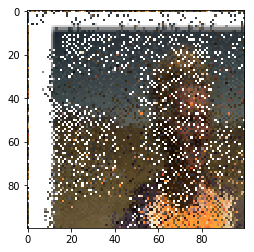

In [395]:
plt.imshow(img.transpose(2,1,0)[:,:,::-1])

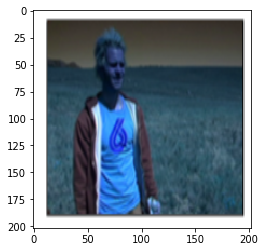

In [40]:
plt.imshow(pm.a_padded.transpose(2,1,0))

In [45]:
pm.a.shape

(3, 200, 200)

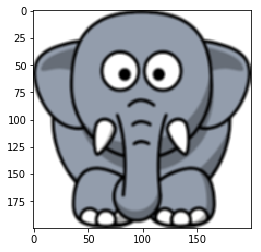

In [82]:
pm.reconstruct_img()